# ICD Tokenize

The data set is a list of ICD labels and their descriptions.  
The goal is to tokenize the descriptions and train a model to predict the ICD labels.

## Data

In [2]:
import ast
import pandas as pd

df = pd.read_csv('data.csv')
df["catalogs"] = df["catalogs"].apply(ast.literal_eval)
display(df)

,id,catalogs,text
0,0,[肝癌],肝癌末期
1,1,[心肺衰竭],心肺衰竭
2,2,[心血管疾病],心血管疾病
3,3,[心肺衰竭],心肺衰竭
4,4,"[糖尿病, 心臟病, 中風, 新冠肺炎]",糖尿病、心臟病、中風、新冠肺炎去年解隔
...,...,...,...
623658,623658,[心肺衰竭],心肺衰竭
623659,623659,[心血管疾病],心血管疾病
623660,623660,[高血壓],高血壓
623661,623661,[老邁],老邁


Most of the descriptions are pretty short and maximum do not exceed 61.

<Axes: xlabel='text'>

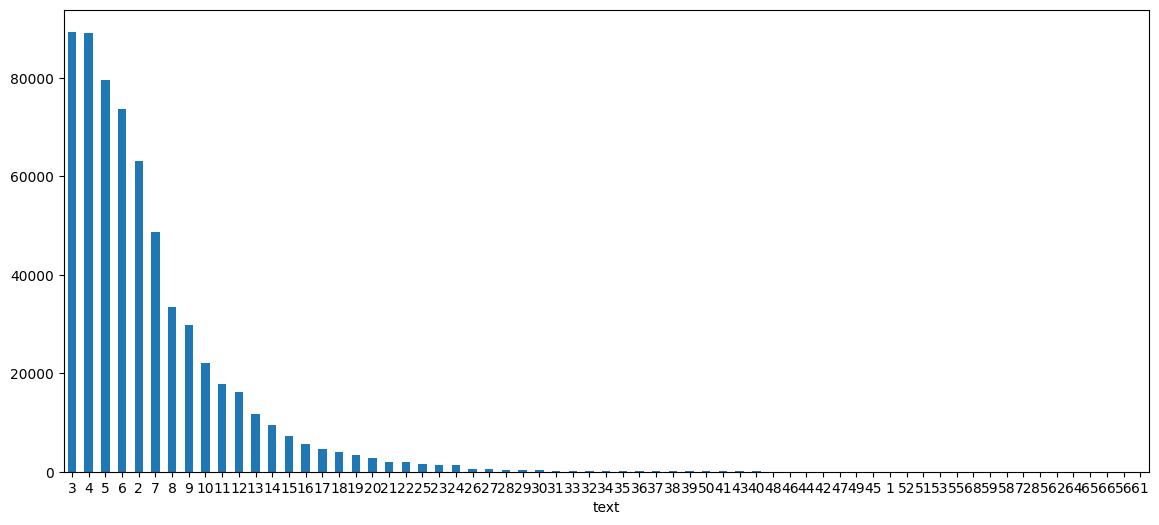

In [3]:
display(df['text'].str.len().value_counts().plot(kind='bar', rot=0, figsize=(14, 6)))

Most of the descriptions only have one or two ICD labels.

<Axes: xlabel='catalogs'>

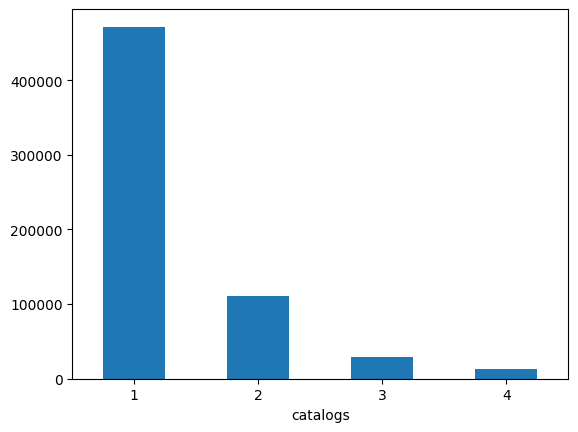

In [4]:
df['catalogs'].apply(len).value_counts().plot(kind='bar',rot=0)

The labels are highly imbalanced and there are more than 14k labels.  
One possible solution is to trim the labels that have less than 1000 samples.

In [5]:
catalogs = df['catalogs'].tolist()
labels = [label for catalog in catalogs for label in catalog]
labels_count = pd.Series(labels).value_counts()
display(labels_count)
# display(labels_count.plot(rot=30, figsize=(12, 6)))

肺炎                 62907
高血壓                38049
呼吸衰竭               36682
心肺衰竭               35438
糖尿病                34698
                   ...  
哮喘性支氣管炎                1
高血糖高滲透性非酮酸中毒性昏迷        1
多發性淋巴腫                 1
陳舊性心絞痛                 1
多發性腦轉移                 1
Name: count, Length: 14854, dtype: int64

In [6]:
select = 100
total_counts = labels_count.sum()
labels_count = labels_count.sort_values(ascending=False)
majority_class = labels_count.head(select)
print(f"{len(majority_class)} labels account for {select/len(labels_count)*100:.2f}% of the labels and {majority_class.sum() / total_counts * 100:.2f}% of the data")

100 labels account for 0.67% of the labels and 68.66% of the data


## Pre-processing

### Multi Label Binarizer

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform(df['catalogs'])
new_df = pd.DataFrame(mlb_result, columns=mlb.classes_)
new_df['text'] = df["text"]
new_df

,18三套體,18對短臂症候群,220伏特電擊,3染色体13症,7-AMINOFLUNITRAZEPAM,AIDS,AIDS帶原者,ALK陰性退行性大細胞淋巴瘤,ALPRAZOLAM中毒,Alstrom氏症候群,...,齒齦惡性腫瘤,齒齦癌,齒齦腫瘤,齒齦鱗狀上皮癌,齒齦鱗狀細胞癌,龍發威殺蟲劑中毒,龐貝氏症,龜頭惡性腫瘤,龜頭發炎,text
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,肝癌末期
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,心肺衰竭
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,心血管疾病
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,心肺衰竭
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,糖尿病、心臟病、中風、新冠肺炎去年解隔
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,心肺衰竭
623659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,心血管疾病
623660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,高血壓
623661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,老邁


## Training

### Configuration
Defining some key variables that will be used later on in the training

In [8]:
MODEL_CHECKPOINT = "bert-base-chinese"
BATCH_SIZE = 128
EPOCHS = 1
MAX_LEN = 80
LEARNING_RATE = 1e-05

### Dataset

In [9]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, classes):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.text = dataframe['text']
        self.target = dataframe[classes]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        description = self.text.iloc[index]
        item = self.tokenizer(description, truncation=True, max_length=MAX_LEN, padding='max_length')
        item['labels'] = self.target.iloc[index].values.astype(float)
        return item

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, use_fast=True)

### Split Training and Testing set

In [11]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(new_df, test_size=0.2, random_state=13)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, mlb.classes_)
testing_set = CustomDataset(test_dataset, tokenizer, mlb.classes_)

FULL Dataset: (623663, 14855)
TRAIN Dataset: (498930, 14855)
TEST Dataset: (124733, 14855)


In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification")

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
from transformers import TrainingArguments

model_name = MODEL_CHECKPOINT.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-icd-{len(mlb.classes_)}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit=10,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    load_best_model_at_end=True
)

In [14]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=training_set,
    eval_dataset=testing_set,
    tokenizer=tokenizer
)

In [15]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ubuntu/Eddie/icd-tokenize/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.000600,0.000615


TrainOutput(global_step=15592, training_loss=0.012661609805598587, metrics={'train_runtime': 3642.4051, 'train_samples_per_second': 136.978, 'train_steps_per_second': 4.281, 'total_flos': 2.32467815182752e+16, 'train_loss': 0.012661609805598587, 'epoch': 1.0})